In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
import matplotlib.pyplot as plt

class LeNetPyTorch(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNetPyTorch, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def train_pytorch_lenet(epochs=10):
    # Принудительно используем CPU
    device = torch.device("cpu")
    print(f"PyTorch использует: {device}")
    
    # Преобразования данных
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Загрузка данных
    train_dataset = torchvision.datasets.FashionMNIST(
        root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.FashionMNIST(
        root='./data', train=False, download=True, transform=transform)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=128, shuffle=True, num_workers=0)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=128, shuffle=False, num_workers=0)
    
    # Создание модели
    model = LeNetPyTorch().to(device)
    
    # Подсчет параметров
    pytorch_params = sum(p.numel() for p in model.parameters())
    print(f"Количество параметров PyTorch: {pytorch_params:,}")
    
    # Оптимизатор и функция потерь
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Обучение
    train_losses = []
    train_accuracies = []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        epoch_start = time.time()
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
        epoch_time = time.time() - epoch_start
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Time: {epoch_time:.2f}s')
    
    training_time = time.time() - start_time
    
    # Тестирование
    model.eval()
    correct = 0
    total = 0
    test_times = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            start_inference = time.time()
            outputs = model(data)
            test_times.append(time.time() - start_inference)
            
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    avg_inference_time = np.mean(test_times) / len(data) * 1000  # мс на изображение
    
    return accuracy, training_time, avg_inference_time, train_losses, train_accuracies, pytorch_params

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time

# Принудительно отключаем GPU для честного сравнения
tf.config.set_visible_devices([], 'GPU')

def build_keras_lenet():
    model = keras.Sequential([
        layers.Conv2D(6, (5, 5), activation='relu', input_shape=(28, 28, 1), padding='same'),
        layers.AveragePooling2D((2, 2)),
        layers.Conv2D(16, (5, 5), activation='relu'),
        layers.AveragePooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(120, activation='relu'),
        layers.Dense(84, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

def train_keras_lenet(epochs=10):
    print(f"Keras использует: CPU")
    
    # Загрузка данных
    (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
    
    # Предобработка
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    
    # Создание модели
    model = build_keras_lenet()
    
    # Подсчет параметров
    keras_params = model.count_params()
    print(f"Количество параметров Keras: {keras_params:,}")
    
    # Компиляция
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Обучение
    start_time = time.time()
    
    history = model.fit(
        x_train, y_train,
        batch_size=128,
        epochs=epochs,
        validation_data=(x_test, y_test),
        verbose=1
    )
    
    training_time = time.time() - start_time
    
    # Тестирование скорости инференса
    test_times = []
    for i in range(100):
        start_inference = time.time()
        _ = model.predict(x_test[i:i+1], verbose=0)
        test_times.append(time.time() - start_inference)
    
    avg_inference_time = np.mean(test_times) * 1000  # мс на изображение
    
    # Оценка точности
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    # ИСПРАВЛЕНИЕ: Убедимся, что данные имеют правильную размерность
    keras_accuracies = history.history['accuracy']
    keras_losses = history.history['loss']
    
    # Преобразуем accuracy в проценты
    keras_accuracies_percent = [acc * 100 for acc in keras_accuracies]
    
    print(f"Отладочная информация:")
    print(f"Количество эпох: {epochs}")
    print(f"Длина history['accuracy']: {len(keras_accuracies)}")
    print(f"Длина history['loss']: {len(keras_losses)}")
    print(f"Пример значений accuracy: {keras_accuracies[:3]}")
    print(f"Пример значений accuracy в %: {keras_accuracies_percent[:3]}")
    
    return test_accuracy * 100, training_time, avg_inference_time, keras_losses, keras_accuracies_percent, keras_params

СРАВНЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ LENET НА CPU

PYTORCH LENET
PyTorch использует: cpu
Количество параметров PyTorch: 61,706
Epoch 1/10, Loss: 0.7088, Accuracy: 73.59%, Time: 17.61s
Epoch 2/10, Loss: 0.4577, Accuracy: 83.16%, Time: 17.39s
Epoch 3/10, Loss: 0.3854, Accuracy: 85.86%, Time: 17.36s
Epoch 4/10, Loss: 0.3486, Accuracy: 87.17%, Time: 17.58s
Epoch 5/10, Loss: 0.3224, Accuracy: 88.06%, Time: 20.58s
Epoch 6/10, Loss: 0.3055, Accuracy: 88.72%, Time: 17.33s
Epoch 7/10, Loss: 0.2885, Accuracy: 89.33%, Time: 17.36s
Epoch 8/10, Loss: 0.2756, Accuracy: 89.87%, Time: 17.57s
Epoch 9/10, Loss: 0.2622, Accuracy: 90.28%, Time: 17.56s
Epoch 10/10, Loss: 0.2515, Accuracy: 90.67%, Time: 17.47s

KERAS LENET
Keras использует: CPU
Количество параметров Keras: 61,706
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7357 - loss: 0.7161 - val_accuracy: 0.7897 - val_loss: 0.5620
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8232 - loss: 0.4841 - val_accuracy: 0.8207 - 

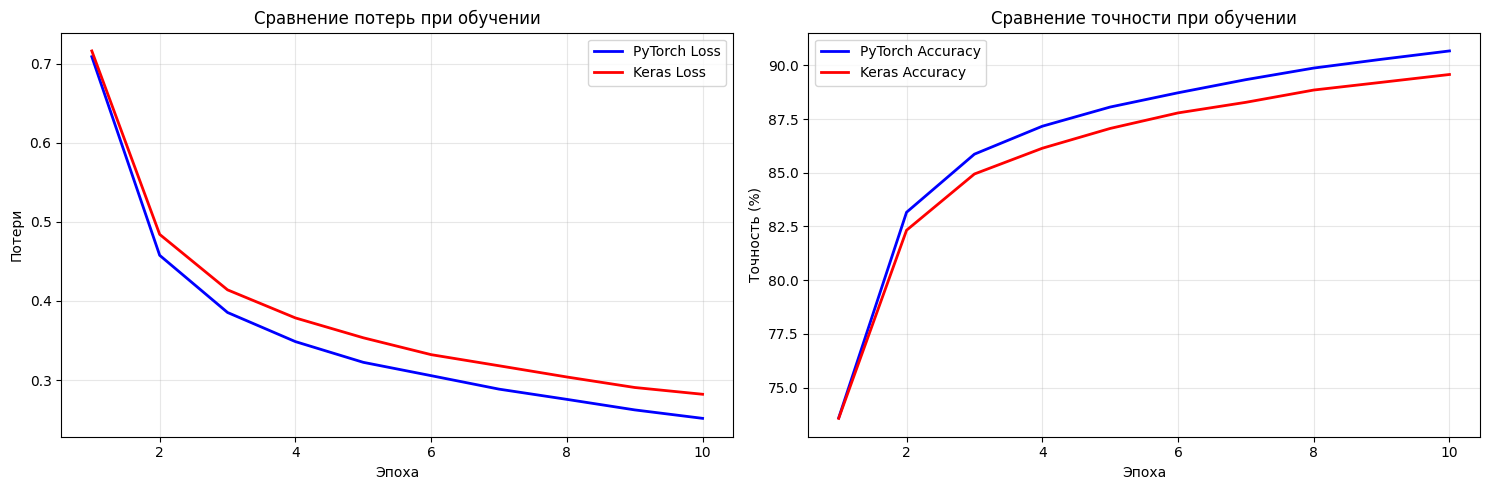


ДЕТАЛЬНОЕ СРАВНЕНИЕ
Метрика                   PyTorch         Keras           Разница        
----------------------------------------------------------------------
Точность (%):             88.93           87.92           1.01           
Время обучения (с):       177.81          35.50           142.31         
Время инференса (мс):     0.163           70.157          69.994         
Параметры:                61,706          61,706          0              

АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ
Keras быстрее в обучении на: 80.0%
Относительная скорость обучения: 5.01x
PyTorch быстрее в инференсе на: 99.8%

Использование памяти (оценочно):
PyTorch: ~0.2 MB (параметры + граф)
Keras: ~0.2 MB (параметры + граф)


In [7]:
def comprehensive_benchmark():
    print("=" * 60)
    print("СРАВНЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ LENET НА CPU")
    print("=" * 60)
    
    epochs = 10
    
    # PyTorch
    print("\n" + "=" * 30)
    print("PYTORCH LENET")
    print("=" * 30)
    pytorch_acc, pytorch_time, pytorch_inference, pytorch_losses, pytorch_accuracies, pytorch_params = train_pytorch_lenet(epochs)
    
    # Keras
    print("\n" + "=" * 30)
    print("KERAS LENET")
    print("=" * 30)
    keras_acc, keras_time, keras_inference, keras_losses, keras_accuracies, keras_params = train_keras_lenet(epochs)
    
    # Визуализация результатов
    plot_comparison(pytorch_losses, pytorch_accuracies, keras_losses, keras_accuracies, epochs)
    
    # Детальное сравнение
    print("\n" + "=" * 60)
    print("ДЕТАЛЬНОЕ СРАВНЕНИЕ")
    print("=" * 60)
    
    print(f"{'Метрика':<25} {'PyTorch':<15} {'Keras':<15} {'Разница':<15}")
    print("-" * 70)
    print(f"{'Точность (%):':<25} {pytorch_acc:<15.2f} {keras_acc:<15.2f} {abs(pytorch_acc-keras_acc):<15.2f}")
    print(f"{'Время обучения (с):':<25} {pytorch_time:<15.2f} {keras_time:<15.2f} {abs(pytorch_time-keras_time):<15.2f}")
    print(f"{'Время инференса (мс):':<25} {pytorch_inference:<15.3f} {keras_inference:<15.3f} {abs(pytorch_inference-keras_inference):<15.3f}")
    print(f"{'Параметры:':<25} {pytorch_params:<15,} {keras_params:<15,} {abs(pytorch_params-keras_params):<15,}")
    
    # Анализ производительности
    print("\n" + "=" * 60)
    print("АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ")
    print("=" * 60)
    
    if pytorch_time < keras_time:
        speed_diff = ((keras_time - pytorch_time) / keras_time) * 100
        print(f"PyTorch быстрее в обучении на: {speed_diff:.1f}%")
        print(f"Относительная скорость обучения: {keras_time/pytorch_time:.2f}x")
    else:
        speed_diff = ((pytorch_time - keras_time) / pytorch_time) * 100
        print(f"Keras быстрее в обучении на: {speed_diff:.1f}%")
        print(f"Относительная скорость обучения: {pytorch_time/keras_time:.2f}x")
    
    if pytorch_inference < keras_inference:
        inference_diff = ((keras_inference - pytorch_inference) / keras_inference) * 100
        print(f"PyTorch быстрее в инференсе на: {inference_diff:.1f}%")
    else:
        inference_diff = ((pytorch_inference - keras_inference) / pytorch_inference) * 100
        print(f"Keras быстрее в инференсе на: {inference_diff:.1f}%")
    
    # Использование памяти (оценочно)
    print(f"\nИспользование памяти (оценочно):")
    print(f"PyTorch: ~{pytorch_params * 4 / 1024 / 1024:.1f} MB (параметры + граф)")
    print(f"Keras: ~{keras_params * 4 / 1024 / 1024:.1f} MB (параметры + граф)")

def plot_comparison(pytorch_losses, pytorch_accuracies, keras_losses, keras_accuracies, epochs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Определяем фактическое количество эпох для графиков
    actual_epochs = min(len(pytorch_losses), len(keras_losses))
    epochs_range = list(range(1, actual_epochs + 1))
    
    print(f"Фактическое количество эпох для графиков: {actual_epochs}")
    print(f"PyTorch - losses: {len(pytorch_losses)}, accuracy: {len(pytorch_accuracies)}")
    print(f"Keras - losses: {len(keras_losses)}, accuracy: {len(keras_accuracies)}")
    
    # Обрезаем данные до actual_epochs
    pytorch_losses = pytorch_losses[:actual_epochs]
    pytorch_accuracies = pytorch_accuracies[:actual_epochs]
    keras_losses = keras_losses[:actual_epochs]
    keras_accuracies = keras_accuracies[:actual_epochs]
    
    # График потерь
    ax1.plot(epochs_range, pytorch_losses, 'b-', linewidth=2, label='PyTorch Loss')
    ax1.plot(epochs_range, keras_losses, 'r-', linewidth=2, label='Keras Loss')
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('Потери')
    ax1.set_title('Сравнение потерь при обучении')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График точности
    ax2.plot(epochs_range, pytorch_accuracies, 'b-', linewidth=2, label='PyTorch Accuracy')
    ax2.plot(epochs_range, keras_accuracies, 'r-', linewidth=2, label='Keras Accuracy')
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('Точность (%)')
    ax2.set_title('Сравнение точности при обучении')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Запуск сравнения
if __name__ == "__main__":
    comprehensive_benchmark()